In [6]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh
import matplotlib.pyplot as plt
import os, sys, pathlib
import numpy as np
import xarray as xr
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))
sys.path.append(os.path.join(r'/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions/source_functions.py'))

from convergence_functions import *
from plotting_functions import *
from source_functions import *

from matplotlib.ticker import LogFormatter

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
rise_FL = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week_10/rise_time/loarte_profile/q_0/case_07_rise_time_100_more_data_points')


In [35]:
def q_electron(ds):
    y = ds['y'].values
    t = ds['t'].values # Convert time to milliseconds
    kappa_e = ds['kappa_par_e'].values.reshape(len(t), len(y))
    Te = ds['Te'].values.reshape(len(t), len(y))

    # Apply replace_guards to each time slice
    kappa_e = np.apply_along_axis(replace_guards, axis=1, arr=kappa_e)
    Te = np.apply_along_axis(replace_guards, axis=1, arr=Te)

    # Calculate the gradient of Te along the y-axis
    grad_T = np.gradient(Te, axis=1)
    q = -kappa_e * grad_T

    return q

def heatflux_t_profile(ds, location='target', normalise=False):
    """
    Calculate the heat flux profile at the specified location over time.

    Parameters:
        ds (xarray.Dataset): Dataset containing the relevant data arrays.
        location (str): Location to compute the heat flux ('target', 'xpoint', or 'upstream').
        normalise (bool): If True, normalise the results by the minimum value of the flux.

    Returns:
        list or np.ndarray: Heat flux profile at the specified location.
    """
    t = ds['t'].values * 1e3  # Convert time to milliseconds
    xpoint_location = ds.options['mesh']['length_xpt']
    y = ds['y'].values

    target_flux = []
    xpoint_flux = []

    # Find x-point index based on location
    x_point_index = np.argmin(np.abs(y - xpoint_location))

    # Ensure that kappa_e and Te are reshaped to 2D [time, y]
    kappa_e = ds['kappa_par_e'].values.reshape(len(t), len(y))
    Te = ds['Te'].values.reshape(len(t), len(y))

    # Apply replace_guards to each time slice
    kappa_e = np.apply_along_axis(replace_guards, axis=1, arr=kappa_e)
    Te = np.apply_along_axis(replace_guards, axis=1, arr=Te)

    # Calculate the gradient of Te along the y-axis
    grad_T = np.gradient(Te, axis=1)
    q = -kappa_e * grad_T

    if location == 'target':
        # Collect heat flux at the target (last index along y-axis)
        for indx in range(len(t)):
            target_flux.append(np.sum(q[indx, -20]))

        result = np.array(target_flux)

    elif location == 'xpoint':
        # Collect heat flux at the x-point location
        for indx in range(len(t)):
            xpoint_flux.append(np.sum(q[indx, x_point_index]))

        result = np.array(xpoint_flux)

    elif location == 'upstream':
        # Collect upstream source flux directly without modification
        src = ds['SPe'].values.reshape(len(t), len(y))
        result = src[:, 0]

    else:
        raise ValueError("Invalid location specified. Choose 'target', 'xpoint', or 'upstream'.")

    # Normalise the result if the normalise argument is True
    if normalise:
        result = result / np.min(result)

    return result



    

In [36]:
def find_fall_time_and_index(x, y, threshold_factor=0.01):

    # Find the peak index and value
    peak_index = np.argmax(y)
    peak_value = y[peak_index]

    # Calculate the threshold
    threshold = threshold_factor * peak_value

    # Find the first index after the peak where y falls below the threshold
    indices_below_threshold = np.where(y[peak_index:] <= threshold)[0]
    if len(indices_below_threshold) > 0:
        fall_index = peak_index + indices_below_threshold[0]
        fall_time = x[fall_index]
        return fall_time, fall_index
    else:
        # If no values are below the threshold, return None
        return None, None

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

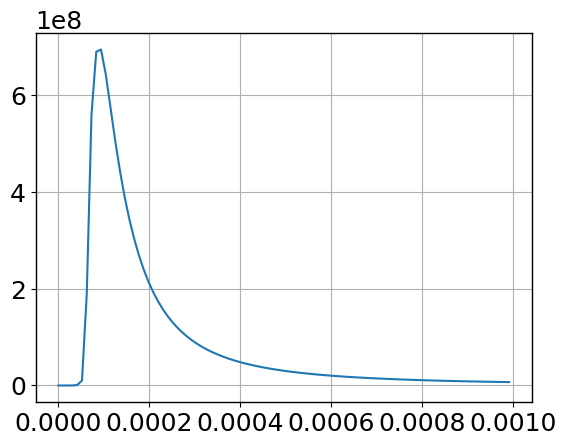

In [37]:
heatflux_80 = heatflux_t_profile(rise_FL, location='target', normalise=False)
upstream_80 = heatflux_t_profile(rise_FL, location='xpoint', normalise=False)
source_80 = heatflux_t_profile(rise_FL, location='upstream', normalise=False)
t_FL = rise_FL['t'].values
t_FL = np.maximum(t_FL - t_FL[0], 1e-9)


# Truncate the time array and corresponding data
pulse_start = 0.5e-3
truncated_indices = t_FL >= pulse_start
print(truncated_indices)
t_FL = t_FL[truncated_indices]
t_FL = np.maximum(t_FL - t_FL[0], 1e-9)
heatflux_80 = heatflux_80[truncated_indices]  # Replace 'y' with your data array
heatflux_80 = heatflux_80 - np.min(heatflux_80)
upstream_80 = upstream_80[truncated_indices]
upstream_80 = upstream_80 - np.min(upstream_80)
source_80 = source_80[truncated_indices]
source_80 = source_80 - np.min(source_80)

time, index = find_fall_time_and_index(t_FL, heatflux_80, threshold_factor=0.01)

t_FL = t_FL[:index]
heatflux_80 = heatflux_80[:index]
upstream_80 = upstream_80[:index]
source_80 = source_80[:index]



# t = t[np.argmax(np.abs(t-1e-3)):]

plt.plot(t_FL, heatflux_80, label='80 us')

# SNB 

In [38]:
rise_SNB = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week_10/rise_time/loarte_profile/q_0/case_07_rise_time_100_SNB_more_data_points')

In [39]:
from scipy.integrate import cumtrapz
import numpy as np

def divq_integrate(slice_data, snb_int=False):
    """
    Calculate the total heat flux from the divergence of the Spitzer-Harm fluxes.
    If snb_int == True, outputs the integral of divq_snb, otherwise outputs the integral of divq_sh.
    """
    x = np.ravel(slice_data['y'])[1:-1]  # Extract 'y' array directly
    div_q_snb = replace_guards(np.ravel(slice_data['Div_Q_SNB']))  # Extract 'Div_Q_SNB' array directly
    div_q_sh = replace_guards(np.ravel(slice_data['Div_Q_SH']))  # Extract 'Div_Q_SH' array directly

    q_snb = cumtrapz(div_q_snb, x, initial=0)  # Integrate using cumulative trapezoidal rule
    q_sh = cumtrapz(div_q_sh, x, initial=0)

    return q_snb if snb_int else q_sh



def heatflux_t_profile_snb(ds, location='target', normalise=False, use_divq=False, snb_int=False):
    """
    Calculate the heat flux profile at the specified location over time.
    """
    t = ds['t'].values * 1e3  # Convert time to milliseconds
    xpoint_location = ds.options['mesh']['length_xpt']
    y = ds['y'].values

    target_flux = []
    xpoint_flux = []

    # Find x-point index based on location
    x_point_index = np.argmin(np.abs(y - xpoint_location))

    for indx in range(len(t)):
        if use_divq:
            # Create slice data for divq_integrate
            slice_data = {
                'y': y,
                'Div_Q_SNB': ds['Div_Q_SNB'].isel(t=indx).values,
                'Div_Q_SH': ds['Div_Q_SH'].isel(t=indx).values
            }
            q = divq_integrate(slice_data, snb_int=snb_int)

            if location == 'target':
                target_flux.append(q[-1])  # Target flux at the end of the domain
            elif location == 'xpoint':
                xpoint_flux.append(q[x_point_index])  # Flux at the x-point location
        elif location != 'upstream':
            # Use Spitzer-Harm flux calculations
            kappa_e = ds['kappa_par_e'].isel(t=indx).values
            Te = ds['Te'].isel(t=indx).values
            kappa_e = replace_guards(np.squeeze(kappa_e))
            Te = replace_guards(np.squeeze(Te))

            grad_T = np.gradient(Te, y)
            q = -kappa_e * grad_T

            if location == 'target':
                target_flux.append(np.sum(q[-20]))
            elif location == 'xpoint':
                xpoint_flux.append(np.sum(q[x_point_index]))
        else:
            # Use upstream source flux directly
            src = ds['Pe_src'].isel(t=indx).values
            result = src[0]

    result = None
    if location == 'target':
        result = np.array(target_flux)
    elif location == 'xpoint':
        result = np.array(xpoint_flux)
    elif location == 'upstream':
        src = ds['Pe_src'].values.reshape(len(t), len(y))
        result = src[:, 0]
    else:
        raise ValueError("Invalid location specified. Choose 'target', 'xpoint', or 'upstream'.")

    if normalise:
        result = result / np.min(result)

    return result

In [40]:
heatflux_snb = heatflux_t_profile_snb(rise_SNB, location='target', normalise=False, use_divq=True, snb_int=True)
upstream_snb = heatflux_t_profile_snb(rise_SNB, location='xpoint', normalise=False, use_divq=True, snb_int=True)
source_snb = heatflux_t_profile_snb(rise_SNB, location='upstream', normalise=False, use_divq=False, snb_int=False)



In [41]:

t_snb = rise_SNB['t'].values
t_snb = np.maximum(t_snb - t_snb[0], 1e-9)

print(t_snb)

# Truncate the time array and corresponding data
pulse_start = 0.5e-3
truncated_indices = t_snb >= pulse_start
# truncated_indices = t >= pulse_start
# print(truncated_indices)
t_snb = t_snb[truncated_indices]
t_snb = np.maximum(t_snb - t_snb[0], 1e-9)

heatflux_snb = heatflux_snb[truncated_indices]  # Replace 'y' with your data array
heatflux_snb = heatflux_snb - np.min(heatflux_snb)
upstream_snb = upstream_snb[truncated_indices]
upstream_snb = upstream_snb - np.min(upstream_snb)
source_snb = source_snb[truncated_indices]
source_snb = source_snb - np.min(source_snb)

time, index = find_fall_time_and_index(t_snb, heatflux_snb, threshold_factor=0.01)

t_snb = t_snb[:index]

heatflux_snb = heatflux_snb[:index]
upstream_snb = upstream_snb[:index]
source_snb = source_snb[:index]


# t = t[np.argmax(np.abs(t-1e-3):]

[1.00000000e-09 1.04396848e-05 2.08793695e-05 3.13190543e-05
 4.17587390e-05 5.21984238e-05 6.26381085e-05 7.30777933e-05
 8.35174780e-05 9.39571628e-05 1.04396848e-04 1.14836532e-04
 1.25276217e-04 1.35715902e-04 1.46155587e-04 1.56595271e-04
 1.67034956e-04 1.77474641e-04 1.87914326e-04 1.98354010e-04
 2.08793695e-04 2.19233380e-04 2.29673065e-04 2.40112749e-04
 2.50552434e-04 2.60992119e-04 2.71431804e-04 2.81871488e-04
 2.92311173e-04 3.02750858e-04 3.13190543e-04 3.23630227e-04
 3.34069912e-04 3.44509597e-04 3.54949282e-04 3.65388966e-04
 3.75828651e-04 3.86268336e-04 3.96708021e-04 4.07147705e-04
 4.17587390e-04 4.28027075e-04 4.38466760e-04 4.48906444e-04
 4.59346129e-04 4.69785814e-04 4.80225499e-04 4.90665183e-04
 5.01104868e-04 5.11544553e-04 5.21984238e-04 5.32423922e-04
 5.42863607e-04 5.53303292e-04 5.63742977e-04 5.74182661e-04
 5.84622346e-04 5.95062031e-04 6.05501716e-04 6.15941401e-04
 6.26381085e-04 6.36820770e-04 6.47260455e-04 6.57700140e-04
 6.68139824e-04 6.785795

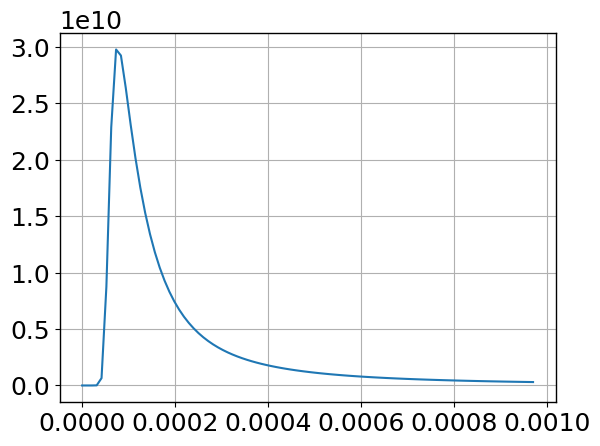

In [42]:
plt.plot(t_snb, heatflux_snb, label='SNB')

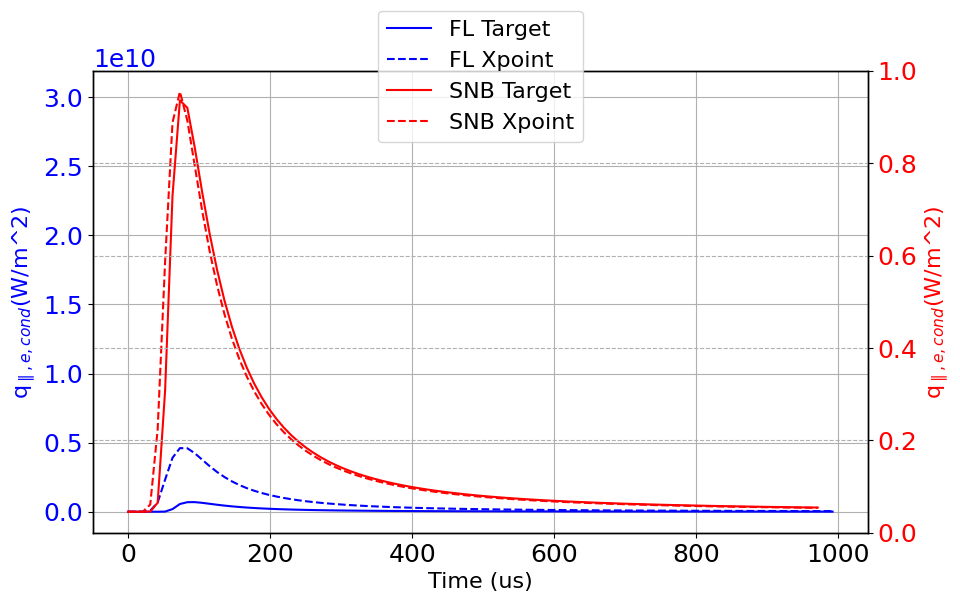

In [45]:
fig,ax = plt.subplots(1,1, figsize=(10,6))
# ax2 = ax.twinx()

# t_FL += 0.5e-3
# t_snb += 0.5e-3

ax.plot(t_FL * 1e6, heatflux_80, label='FL Target', color = 'blue')
ax.plot(t_FL * 1e6, upstream_80, label='FL Xpoint', linestyle='--', color = 'blue')
ax.set_ylabel(r'q$_{\parallel,e,cond}$(W/m^2)', color='blue')
ax.set_xlabel('Time (us)')
ax.tick_params(axis='y', labelcolor='blue')
# ax.axvline(100, color='black', linestyle='--', label='100 us')

ax.plot(t_snb* 1e6, heatflux_snb, label='SNB Target', color = 'red')
ax.plot(t_snb* 1e6, upstream_snb, label='SNB Xpoint', linestyle='--', color = 'red')
# ax2.set_ylabel(r'q$_{\parallel,e,cond}$(W/m^2)', color='red')
# ax2.grid(True, which='both', linestyle='--')
# ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc='upper center')


# Density rise

In [47]:
density_rise_65 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/50%_fluence/power_and_density/FL/case_01_65')

In [48]:
density_rise_55 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/50%_fluence/power_and_density/FL/case_01_55')

In [49]:

y = density_rise_65['y'].values
# Ne_2x = np.squeeze(density_increase_2x['Ne'].values)
# Ne_4x = np.squeeze(density_increase_4x['Ne'].values)
# Ne_10x = np.squeeze(density_increase_10x['Ne'].values)
# Ne_12x = np.squeeze(density_increase_12x['Ne'].values)
# Ne_10x_50_fluence = np.squeeze(density_10x_50_fluence['Ne'].values)
# Ne_100x_25_fluence = np.squeeze(density_rise['Ne'].values)
# # Ne_80_25_fluence = np.squeeze(density_80_25_fluence['Ne'].values)
# Ne_snb = np.squeeze(snb['Ne'].values)
# Ne_snb_80 = np.squeeze(snb_80['Ne'].values)

ne_35 = np.squeeze(density_rise_65['Ne'].values)
ne_55 = np.squeeze(density_rise_55['Ne'].values)

data_set = {'65 times density': ne_35, '55 times density': ne_55}

for key, value in data_set.items():
    max = np.max(value[:, 0])
    min = np.min(value[:, 0])
    print(f'{key} max: {max}')
    print(f'{key} min: {min}')
    # plt.plot(y, value, label=key)
# print(np.max(Ne))

# max = np.max(Ne[:, 1])

# print(max)

65 times density max: 1.5379835462441658e+20
65 times density min: 7.0093489200135725e+19
55 times density max: 1.4283202316860894e+20
55 times density min: 7.009348920013101e+19


### Animation

In [2]:
FL_50 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/50%_fluence/power_and_density/FL/case_01')
FL_100 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/100%_fluence/power_and_density/FL/case_01')
FL_150 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/150%_fluence/power_and_density/FL/case_01')
FL_200 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/200%_fluence/power_and_density/FL/case_01')
FL_250 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/250%_fluence/power_and_density/FL/case_01')
FL_300 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/300%_fluence/power_and_density/FL/case_01')

In [3]:
def te_ti_ne_nd(ds):
    # select last time step
    data = ds.isel(t=0)

    # Extract the data arrays
    Te = replace_guards(np.squeeze(data['Te'].values))
    Ti = replace_guards(np.squeeze(data['Td+'].values))
    ne = replace_guards(np.squeeze(data['Ne'].values))
    nd = replace_guards(np.squeeze(data['Nd'].values))
    y = data['y'].values[1:-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax2 = ax.twinx()

    ax.plot(y, Te, label='Te', color='blue')
    ax.plot(y, Ti, label='Ti', color='red')

    ax2.plot(y, ne, label='ne', color='blue' , linestyle='--')
    ax2.plot(y, nd, label='ni', color='black', linestyle='--')

    ax.set_ylabel('Te, Ti (eV)')
    ax2.set_ylabel('ne, ni (m^-3)')
    ax2.set_yscale('log')
    ax.set_xlabel(r'$S_{\parallel}$ (m)')
    ax2.grid(linestyle='--', which='major', alpha=0.7)

    fig.legend(loc = 'upper left', ncol=4)

    return fig, ax

# te_ti_ne_nd(test)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoClip

def te_ti_ne_nd_animation(ds, output_file="te_ti_ne_nd_animation.mp4"):
    """
    Create an animation of Te, Ti, ne, nd profiles over time and save it as an MP4.

    Parameters:
    - ds: xarray Dataset containing the data
    - output_file: str, name of the output MP4 file
    """
    # Extract the time dimension
    times = ds['t'].values * 1e3
    times = (times-times[0]) - 0.5
    y = ds['y'].values[1:-1]

    def replace_guards(data):
        # Replace guard cells with NaN (example implementation)
        return data[1:-1]  # Replace with your specific logic

    # Calculate the fixed y-axis limits
    max_Te = -np.inf
    max_Ti = -np.inf
    max_ne = -np.inf
    max_nd = -np.inf

    for t_index in range(len(times)):
        data = ds.isel(t=t_index)
        Te = replace_guards(np.squeeze(data['Te'].values))
        Ti = replace_guards(np.squeeze(data['Td+'].values))
        ne = replace_guards(np.squeeze(data['Ne'].values))
        nd = replace_guards(np.squeeze(data['Nd'].values))
        max_Te = np.nanmax(Te)
        max_Ti = np.nanmax(Ti)
        max_ne = np.nanmax(ne)
        max_nd = np.nanmax(nd)

    # Extract the initial profiles for the semi-transparent trace
    initial_data = ds.isel(t=0)
    initial_Te = replace_guards(np.squeeze(initial_data['Te'].values))
    initial_Ti = replace_guards(np.squeeze(initial_data['Td+'].values))
    initial_ne = replace_guards(np.squeeze(initial_data['Ne'].values))
    initial_nd = replace_guards(np.squeeze(initial_data['Nd'].values))

    def make_frame(t_index):
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax2 = ax.twinx()

        # Extract data for the current time slice
        data = ds.isel(t=t_index)
        Te = replace_guards(np.squeeze(data['Te'].values))
        Ti = replace_guards(np.squeeze(data['Td+'].values))
        ne = replace_guards(np.squeeze(data['Ne'].values))
        nd = replace_guards(np.squeeze(data['Nd'].values))

        # Plot initial profiles as semi-transparent traces
        ax.plot(y, initial_Te, color='blue', alpha=0.5, linestyle='-')
        ax.plot(y, initial_Ti,  color='red', alpha=0.5, linestyle='-')
        ax2.plot(y, initial_ne, color='blue', alpha=0.5, linestyle='--')
        ax2.plot(y, initial_nd,  color='black', alpha=0.5, linestyle='--')

        # Plot profiles for the current time slice
        ax.plot(y, Te, label='Te', color='blue')
        ax.plot(y, Ti, label='Ti', color='red')
        ax2.plot(y, ne, label='ne', color='blue', linestyle='--')
        ax2.plot(y, nd, label='nd', color='black', linestyle='--')

        # Set axis limits
        ax.set_ylim(0, max(max_Te, max_Ti))
        ax2.set_ylim(1e14, max(max_ne, max_nd))

        # Set labels
        ax.set_ylabel('Te, Ti (eV)')
        ax2.set_ylabel('ne, nd (m^-3)')
        ax2.set_yscale('log')
        ax.set_xlabel(r'$S_{\parallel}$ (m)')
        ax.set_title(f'Time: {times[t_index]:.2e} s')

        # Add legend
        fig.legend(loc='upper left')

        # Convert the figure to an image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Define the video duration and frame rate
    duration = len(times) / 10  # Assume 10 frames per second
    fps = 10

    # Create video using VideoClip
    def make_frame_video(t):
        t_index = int(t * fps)  # Get the frame index
        t_index = min(t_index, len(times) - 1)  # Ensure within bounds
        return make_frame(t_index)

    animation = VideoClip(make_frame_video, duration=duration)
    animation.write_videofile(output_file, fps=fps, codec="libx264")

    print(f"Animation saved to {output_file}")

# Example usage:
# Assuming `ds` is your dataset
# te_ti_ne_nd_animation(test, output_file="te_ti_ne_nd_animation_fixed_y_axis.mp4")


In [5]:
te_ti_ne_nd_animation(FL_300, output_file="FL_density_300.mp4")

KeyboardInterrupt: 